### IDs:
Insert yours IDs to the cell below

ID #1: 324369412

ID #2: 316420132


In [225]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import comb
from scipy import stats
from scipy.stats import ttest_ind, ranksums, kendalltau

In [226]:
# Define file path
csv_path = "AMI_GSE66360_series_matrix.csv"  # Update with the correct path

# Read the CSV file starting from the 60th line
df = pd.read_csv(csv_path, skiprows=59, index_col=0, encoding="utf-8", low_memory=False)

# Remove the first row by position
df = df.iloc[1:].reset_index(drop=True)

In [227]:
# Display basic info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54675 entries, 0 to 54674
Data columns (total 99 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   H       54674 non-null  object
 1   H.1     54674 non-null  object
 2   H.2     54675 non-null  object
 3   H.3     54674 non-null  object
 4   H.4     54674 non-null  object
 5   H.5     54675 non-null  object
 6   H.6     54674 non-null  object
 7   H.7     54675 non-null  object
 8   H.8     54674 non-null  object
 9   H.9     54674 non-null  object
 10  H.10    54673 non-null  object
 11  H.11    54674 non-null  object
 12  H.12    54673 non-null  object
 13  M       54674 non-null  object
 14  M.1     54675 non-null  object
 15  M.2     54675 non-null  object
 16  M.3     54675 non-null  object
 17  M.4     54675 non-null  object
 18  M.5     54674 non-null  object
 19  M.6     54673 non-null  object
 20  M.7     54675 non-null  object
 21  M.8     54675 non-null  object
 22  M.9     54675 non-null

In [228]:
# Show the first few rows
print(df.head())

             H          H.1          H.2          H.3          H.4  \
0  5.866377893  4.948736331  5.148384393  5.064418945  5.017832878   
1   8.22579012  7.525865369  7.764636529  7.198461482  7.831450258   
2   6.17973231  6.628137025  5.859151477  5.974135101  6.793079158   
3  6.179477974   6.58288903  6.602134766  6.545904723  5.911542321   
4  2.792047952   2.69571445  2.580181122  2.712123845  2.723686912   

           H.5          H.6          H.7          H.8          H.9  ...  \
0  5.116153518  5.431328058  5.235270857  5.773528455  6.016415473  ...   
1  7.203591859  7.694550756  7.760259212  8.279814404  7.580840863  ...   
2   6.43522914  6.320546126   6.48359047  6.387779205  6.307065808  ...   
3   6.28542026  6.562315839  6.345887555   6.27280582  5.971847425  ...   
4   2.70668403  2.674746672  2.635149735  2.696649177  2.802862883  ...   

          M.39         M.40         M.41         M.42         M.43  \
0  5.419481538  5.057716465  5.996493392  5.343132759  5.5

In [229]:
# Number of genes (rows)
num_genes = df.shape[0]

print(f"Number of genes profiled: {num_genes}")

Number of genes profiled: 54675


In [230]:
# Number of samples (columns)
num_samples = df.shape[1]

print(f"Total number of samples: {num_samples}")

Total number of samples: 99


In [231]:
healthy_samples = [col for col in df.columns if "H" in col]  # Adjust if needed
mi_samples = [col for col in df.columns if "M" in col]  # Adjust if needed

print(f"Samples in class 'Healthy' (H): {len(healthy_samples)}")
print(f"Samples in class 'Myocardial Infarction' (M): {len(mi_samples)}")

Samples in class 'Healthy' (H): 50
Samples in class 'Myocardial Infarction' (M): 49


In [232]:
# Remove rows with any NaN values (either from missing values or non-numeric entries)
df_cleaned = df.dropna()

# Count remaining genes
num_genes_remaining = df_cleaned.shape[0]

print(f"Number of genes after removing missing, non-numeric, and empty rows: {num_genes_remaining}")

Number of genes after removing missing, non-numeric, and empty rows: 54628


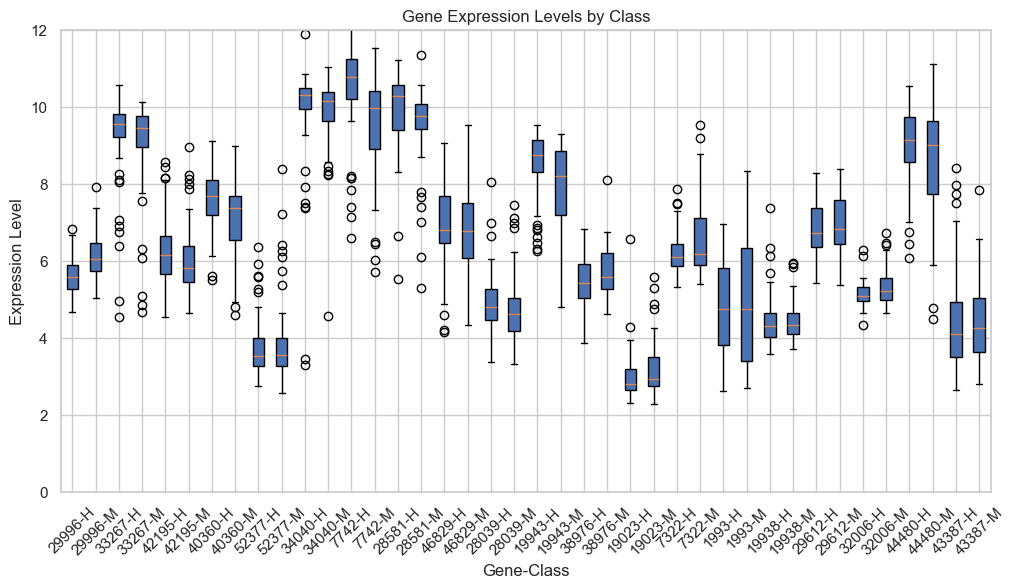

In [233]:
# Select a random sample of 20 genes
genes_to_plot = np.random.choice(df.index, size=20, replace=False)

# Prepare the data for plotting
plot_data = [
    {'Gene': gene, 'Class': cls, 'Expression': df.loc[gene, col]}
    for gene in genes_to_plot
    for col in df.columns
    if (cls := 'H' if col.startswith('H') else 'M' if col.startswith('M') else None)
]

# Convert to DataFrame
plot_df = pd.DataFrame(plot_data)

# Prepare boxplot data
box_data, labels = [], []
for gene in genes_to_plot:
    for class_type in ["H", "M"]:
        subset = plot_df[(plot_df["Gene"] == gene) & (plot_df["Class"] == class_type)]["Expression"].dropna()
        
        # Ensure data is numeric and append it to box_data
        numeric_data = pd.to_numeric(subset, errors='coerce').dropna()
        if not numeric_data.empty:
            box_data.append(numeric_data.to_numpy())
            labels.append(f"{gene}-{class_type}")

# Check for non-numeric values in box_data and remove any non-numeric data
for i, data in enumerate(box_data):
    try:
        # Ensure data is numeric before checking for NaN
        if np.isnan(np.array(data, dtype=float)).any():
            print(f"Warning: Non-numeric values found in box_data[{i}]")
    except ValueError:
        print(f"Warning: Non-numeric values found in box_data[{i}]")

# Plot the box plots
plt.figure(figsize=(12, 6))
plt.boxplot(box_data, tick_labels=labels, patch_artist=True)  # Use tick_labels instead of labels
plt.ylim(0, 12)
plt.xticks(rotation=45)
plt.title("Gene Expression Levels by Class")
plt.xlabel("Gene-Class")
plt.ylabel("Expression Level")
plt.show()


In [234]:
# Define the number of samples in M and H
n_M = len(df.columns[df.columns.str.startswith('M')])  # Number of M samples (columns starting with 'M')
n_H = len(df.columns[df.columns.str.startswith('H')])  # Number of H samples (columns starting with 'H')

# Calculate the total number of samples
n_total = n_M + n_H

# Calculate the expected sum of ranks for M samples under the null hypothesis
expected_sum_ranks_M = (n_M * (n_M + n_H + 1)) // 2

print(f"Expected sum of ranks for M samples under the null hypothesis: {expected_sum_ranks_M}")

Expected sum of ranks for M samples under the null hypothesis: 2450


In [235]:
# Calculate the maximal sum of ranks (RS_max) for gene g in the M group
RS_max = (n_M * (2 * n_H + n_M + 1)) // 2

print(f"Maximal sum of ranks for M samples (RS_max): {RS_max}")

Maximal sum of ranks for M samples (RS_max): 3675


In [236]:
# Total number of ways to choose ranks for M samples
total_ways = comb(n_M + n_H, n_M)

# Probability for RS(g) = c (only one way to achieve this)
P_c = 1 / total_ways

# Probability for RS(g) = c - 1 (choosing one of n_M samples to shift rank)
P_c_minus_1 = n_M / total_ways

# Probability for RS(g) = c - 2 (choosing two M samples to shift ranks)
P_c_minus_2 = (n_M * (n_M - 1) / 2) / total_ways

# Print explanations and results
print("\n### Rank Sum Probabilities under Null Model ###")

print("\n1. Probability of RS(g) = c:")
print("   The maximal rank sum (c) occurs when all M-labeled samples have the highest ranks.")
print("   Since there is only one way to achieve this configuration, the probability is:")
print(f"   P(RS(g) = c) = 1 / comb({n_M + n_H}, {n_M})")
print(f"   P(RS(g) = c) = {P_c}\n")

print("2. Probability of RS(g) = c - 1:")
print("   This occurs when one M-labeled sample shifts down by one rank.")
print("   There are n_M ways to choose which sample shifts, so the probability is:")
print(f"   P(RS(g) = c - 1) = {n_M} / comb({n_M + n_H}, {n_M})")
print(f"   P(RS(g) = c - 1) = {P_c_minus_1}\n")

print("3. Probability of RS(g) = c - 2:")
print("   This happens when two M-labeled samples each shift down by one rank.")
print("   There are n_M * (n_M - 1) / 2 ways to choose which two samples shift, giving:")
print(f"   P(RS(g) = c - 2) = ({n_M} * ({n_M} - 1) / 2) / comb({n_M + n_H}, {n_M})")
print(f"   P(RS(g) = c - 2) = {P_c_minus_2}\n")


### Rank Sum Probabilities under Null Model ###

1. Probability of RS(g) = c:
   The maximal rank sum (c) occurs when all M-labeled samples have the highest ranks.
   Since there is only one way to achieve this configuration, the probability is:
   P(RS(g) = c) = 1 / comb(99, 49)
   P(RS(g) = c) = 1.9823306042836678e-29

2. Probability of RS(g) = c - 1:
   This occurs when one M-labeled sample shifts down by one rank.
   There are n_M ways to choose which sample shifts, so the probability is:
   P(RS(g) = c - 1) = 49 / comb(99, 49)
   P(RS(g) = c - 1) = 9.713419960989972e-28

3. Probability of RS(g) = c - 2:
   This happens when two M-labeled samples each shift down by one rank.
   There are n_M * (n_M - 1) / 2 ways to choose which two samples shift, giving:
   P(RS(g) = c - 2) = (49 * (49 - 1) / 2) / comb(99, 49)
   P(RS(g) = c - 2) = 2.331220790637593e-26



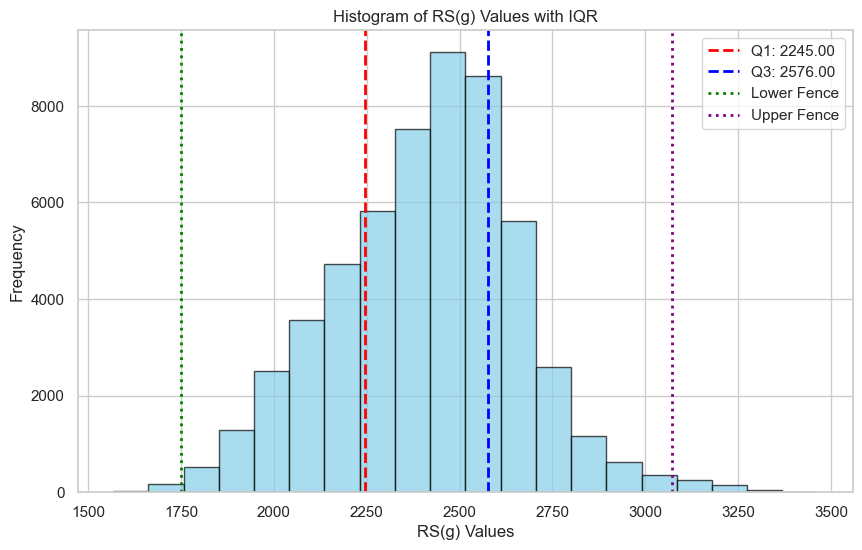

In [239]:
# Identify "M." columns
m_columns = [col for col in df.columns if col.startswith('M.')]

# Function to compute RS(g) for each row
def compute_rs(row):
    sorted_indices = row.sort_values().index  # Sort all columns and get their indices
    ranks = {col: rank + 1 for rank, col in enumerate(sorted_indices)}  # Assign ranks
    
    # Sum the ranks of only "M." columns
    return sum(ranks[col] for col in m_columns)

# Create a copy of df to avoid modifying the original
df_copy = df.copy()

# Compute RS(g) for each row in the copy
df_copy['RS_g'] = df_copy.apply(compute_rs, axis=1)

# Compute IQR
Q1 = df_copy['RS_g'].quantile(0.25)
Q3 = df_copy['RS_g'].quantile(0.75)
IQR = Q3 - Q1

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df_copy['RS_g'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)

# Mark Q1, Q3, and IQR fences
plt.axvline(Q1, color='red', linestyle='dashed', linewidth=2, label=f'Q1: {Q1:.2f}')
plt.axvline(Q3, color='blue', linestyle='dashed', linewidth=2, label=f'Q3: {Q3:.2f}')
plt.axvline(Q1 - 1.5 * IQR, color='green', linestyle='dotted', linewidth=2, label='Lower Fence')
plt.axvline(Q3 + 1.5 * IQR, color='purple', linestyle='dotted', linewidth=2, label='Upper Fence')

plt.xlabel('RS(g) Values')
plt.ylabel('Frequency')
plt.title('Histogram of RS(g) Values with IQR')
plt.legend()
plt.show()

In [240]:
# Create a copy of df to work on
df_copy = df.copy()

# Identify "M" and "H" columns
m_columns = [col for col in df_copy.columns if col.startswith('M.')]
h_columns = [col for col in df_copy.columns if col not in m_columns and col != 'RS_g']  # Exclude RS_g if present

# Convert all numerical columns to float (handle potential string issues)
df_copy[m_columns + h_columns] = df_copy[m_columns + h_columns].apply(pd.to_numeric, errors='coerce')

# Function to evaluate differential expression
def differential_expression(row):
    M_values = row[m_columns].dropna().values  # Remove NaNs if any
    H_values = row[h_columns].dropna().values  # Remove NaNs if any

    if len(M_values) == 0 or len(H_values) == 0:
        return pd.Series([np.nan, np.nan, np.nan, np.nan])  # Handle empty groups safely

    # Student's t-test (one-sided)
    t_stat, t_pval = ttest_ind(M_values, H_values, alternative='greater', nan_policy='omit')  # M > H
    t_stat_inv, t_pval_inv = ttest_ind(M_values, H_values, alternative='less', nan_policy='omit')  # M < H

    # Wilcoxon Rank-Sum Test (WRS)
    wrs_stat, wrs_pval = ranksums(M_values, H_values)  # Two-sided test
    wrs_pval /= 2  # Convert to one-sided
    wrs_stat_inv, wrs_pval_inv = wrs_stat, 1 - wrs_pval  # Reverse direction for M < H

    return pd.Series([t_pval, t_pval_inv, wrs_pval, wrs_pval_inv])

# Apply tests to each gene and store the results in a new DataFrame
test_results = df_copy.apply(differential_expression, axis=1)

# Add the results to the copied DataFrame all at once
df_copy = pd.concat([df_copy, test_results], axis=1)

# Name the new columns
df_copy.columns = list(df_copy.columns[:-4]) + ['t_pval_M>H', 't_pval_M<H', 'wrs_pval_M>H', 'wrs_pval_M<H']

# Count significant genes (p-value ≤ 0.07)
overexpressed_t = (df_copy['t_pval_M>H'] <= 0.07).sum()
underexpressed_t = (df_copy['t_pval_M<H'] <= 0.07).sum()
overexpressed_wrs = (df_copy['wrs_pval_M>H'] <= 0.07).sum()
underexpressed_wrs = (df_copy['wrs_pval_M<H'] <= 0.07).sum()

# Report results
print(f"Overexpressed genes (M > H) at p ≤ 0.07:")
print(f"- Student’s t-test: {overexpressed_t}")
print(f"- WRS test: {overexpressed_wrs}")

print(f"Underexpressed genes (M < H) at p ≤ 0.07:")
print(f"- Student’s t-test: {underexpressed_t}")
print(f"- WRS test: {underexpressed_wrs}")

Overexpressed genes (M > H) at p ≤ 0.07:
- Student’s t-test: 8555
- WRS test: 21411
Underexpressed genes (M < H) at p ≤ 0.07:
- Student’s t-test: 8670
- WRS test: 0


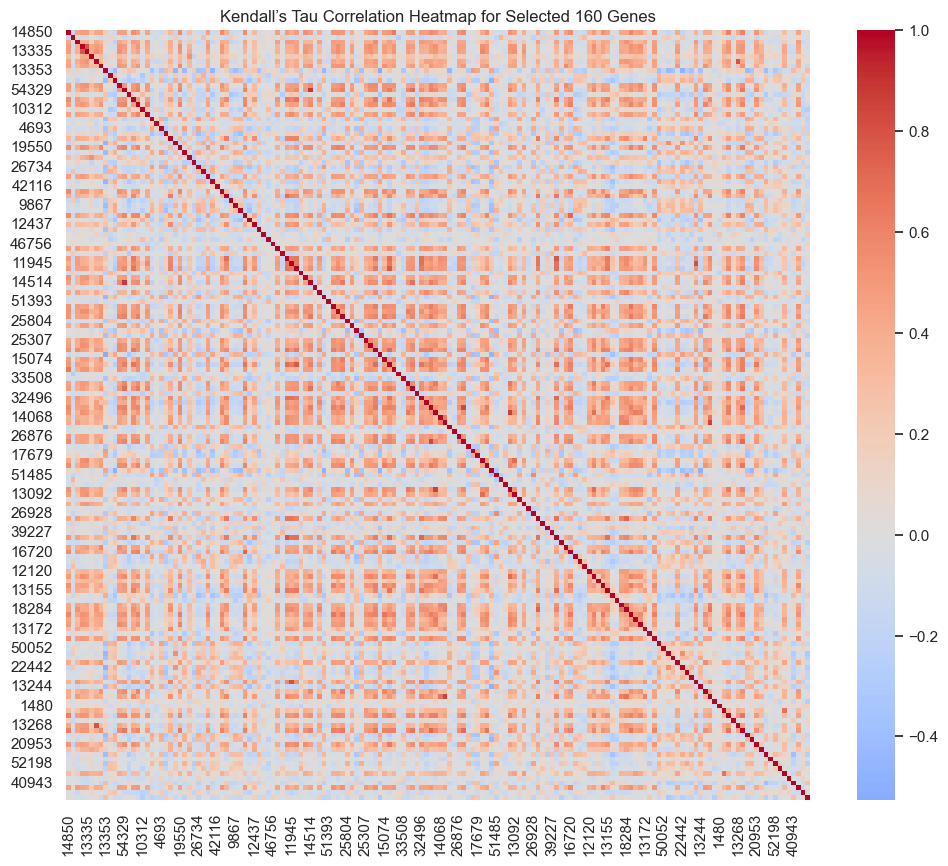

In [241]:
# Select top 80 most significant genes for each case
top_80_overexpressed = df_copy.nsmallest(80, 'wrs_pval_M>H').index
top_80_underexpressed = df_copy.nsmallest(80, 'wrs_pval_M<H').index

# Union of both sets to form the 160-gene set D
D_genes = list(set(top_80_overexpressed) | set(top_80_underexpressed))

# Extract expression data for genes in D
D_data = df_copy.loc[D_genes, m_columns + h_columns]

# Compute Kendall's tau correlation for all pairs
correlation_matrix = D_data.T.corr(method='kendall')  # Transpose so genes are columns

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=False, fmt=".2f")
plt.title("Kendall’s Tau Correlation Heatmap for Selected 160 Genes")
plt.show()

C:\Users\aferdman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 120591 (\N{MATHEMATICAL ITALIC SMALL TAU}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


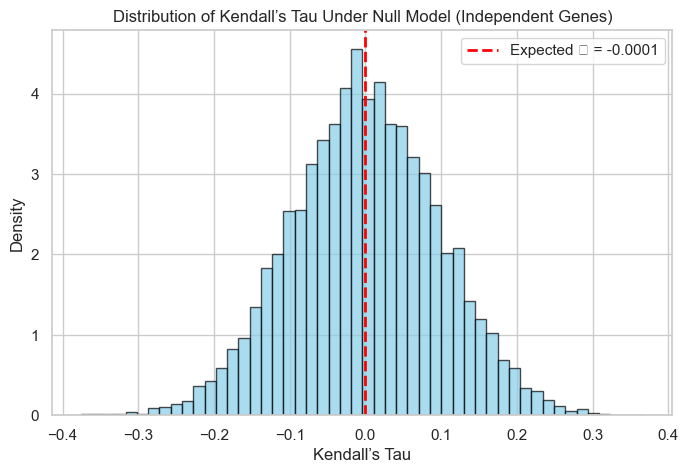

Expected Kendall’s Tau under NULL model: -0.0001


In [242]:
# Number of simulations
num_simulations = 10_000  # Adjust as needed for accuracy

# Number of observations (genes)
n = 50  # You can change this to match your dataset

# Store Kendall's Tau values
tau_values = []

# Simulate random independent rankings
for _ in range(num_simulations):
    x = np.random.rand(n)  # Random values for gene 1
    y = np.random.rand(n)  # Independent random values for gene 2
    tau, _ = stats.kendalltau(x, y)  # Compute Kendall’s Tau
    tau_values.append(tau)

# Compute the expected value (mean of Kendall's Tau)
expected_tau = np.mean(tau_values)

# Plot histogram of Tau values
plt.figure(figsize=(8, 5))
plt.hist(tau_values, bins=50, color='skyblue', edgecolor='black', alpha=0.7, density=True)
plt.axvline(expected_tau, color='red', linestyle='dashed', linewidth=2, label=f'Expected 𝜏 = {expected_tau:.4f}')
plt.xlabel('Kendall’s Tau')
plt.ylabel('Density')
plt.title('Distribution of Kendall’s Tau Under Null Model (Independent Genes)')
plt.legend()
plt.show()

# Print results
print(f"Expected Kendall’s Tau under NULL model: {expected_tau:.4f}")
